This notebook presents an application of the [pydiva2D](./pydiva2d.py) module to perform a 2D Diva analysis and then generate figures for the different input and output using the Basemap module.

In [17]:
import os
import logging
import pydiva2d
import numpy as np
import matplotlib.pyplot as plt
from matplotlib import rcParams
from mpl_toolkits.basemap import Basemap
import subprocess

In [21]:
rcParams['figure.dpi'] = 300
rcParams['font.size'] = 10.0

Suppress mpl_toolkits warnings due to version mismatch:

In [2]:
import warnings
import matplotlib.cbook
warnings.filterwarnings("ignore", category=matplotlib.cbook.mplDeprecation)

If needed, modify the logger level to control the messages displayed on screen (by default: warnings).

In [3]:
logger = logging.getLogger('pydiva2d')
logger.handlers[1].setLevel(logging.WARN)

# Prepare input files and directories

In this example the input files are already created and can be found in the *data* directory.

In [4]:
datadir = '../data/'
datafile = os.path.join(datadir, 'MLD1.dat')
coastfile = os.path.join(datadir, 'coast.cont')
paramfile = os.path.join(datadir, 'param.par')

We also create a directory *figures* where we will save the plots.

In [5]:
figdir = './figures/'
if os.path.exists(figdir):
    logger.debug("Directory {0} already exists".format(figdir))
else:
    logger.debug("Creating directory {0}".format(figdir))
    os.makedirs(figdir)

## Create paths and file names

We create the paths for the Diva directories and files:

In [6]:
divadir = "/home/ctroupin/Software/DIVA/DIVA-diva-4.7.1"
DivaDirs = pydiva2d.DivaDirectories(divadir)
DivaFiles = pydiva2d.Diva2Dfiles(DivaDirs.diva2d)

## Read input files

Let's read the information from the input files.<br>
For each input file, we first creat an object (i.e., **Data**, **Contour** and **Param**) that will allow us to perform operations such as 
* reading, 
* writing, 
* plotting, 
* getting a description.

In [7]:
Data = pydiva2d.Diva2DData().read_from(datafile)
Contour = pydiva2d.Diva2DContours().read_from(coastfile)
Param = pydiva2d.Diva2DParameters().read_from(paramfile)

For example with the parameters:

In [8]:
Param.describe()

Correlation length: 1.0
icoordchange: 2
ispec: 0
ireg: 2
Domain: x-axis: from 27.0 to 42.0 with 151 steps of 0.1
Domain: y-axis: from 40.0 to 47.5 with 76 steps of 0.1
Exclusion value: -99.0
Signal-to-noise ratio: 1.0
Variance of the background field: 0.0


# Make the analysis
We simply call the `make` method of the `Diva2DResults` object:

In [31]:
analysis2d = pydiva2d.Diva2DResults().make(divadir, datafile=datafile,
                                           contourfile=coastfile,
                                           paramfile=paramfile)

The mesh is created if necesarry, so we can load it afterwards:

In [27]:
mesh2d = pydiva2d.Diva2DMesh().read_from(DivaFiles.mesh, DivaFiles.meshtopo)
mesh2d.describe()

Number of nodes: 6447
Number of interfaces: 14059
Number of elements: 7592


# Create the plots

In this example the plots are created using the Basemap module.<br>
All the objects we created have a function *add_to_plot* that takes into account, if it is defined, the selected projection in Basemap.

## Initialise the projection

We will center the map on the region specified by the parameters and with a Mercator projection.<br>
Type `Basemap?` for a list of available projections and options.

In [10]:
m = Basemap(projection='merc', llcrnrlon=Param.xori, llcrnrlat=Param.yori, urcrnrlon=Param.xend,
            urcrnrlat=Param.yend, resolution='i')

## Data points

We use the method **add_to_plot** with 'm' (the projection) as an optional argument.

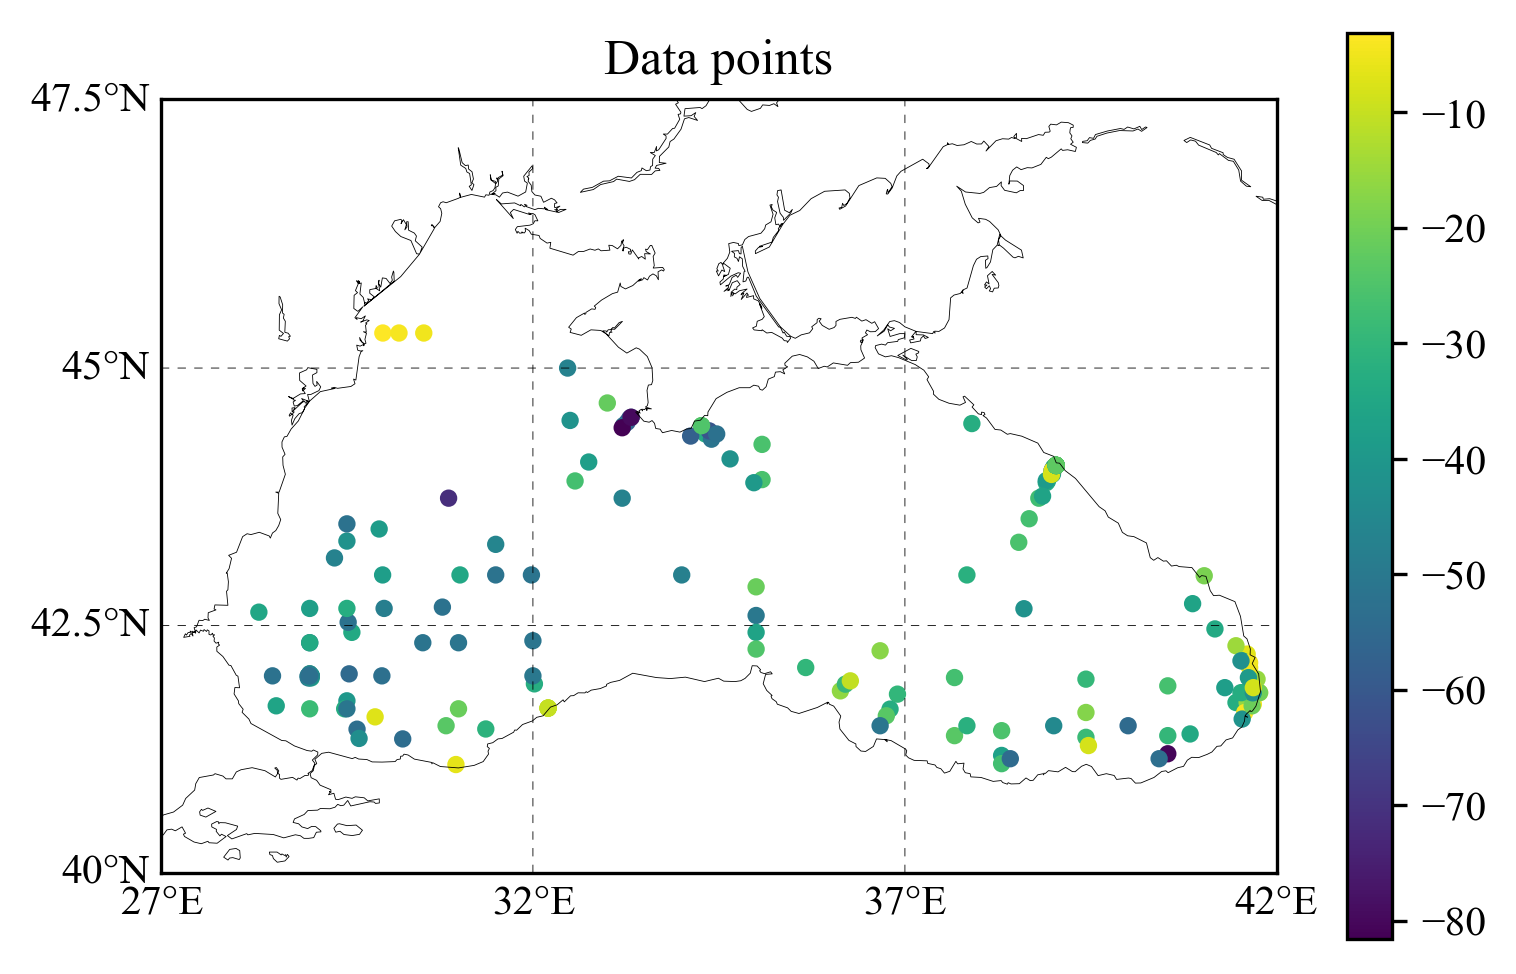

In [22]:
fig = plt.figure()
ax = plt.subplot(111)
m.ax = ax
dataplot = Data.add_to_plot(m=m, s=10)
m.drawmeridians(np.linspace(Param.xori, Param.xend, 4), labels=[0, 0, 0, 1], linewidth=0.2)
m.drawparallels(np.linspace(Param.yori, Param.yend, 4), labels=[1, 0, 0, 0], linewidth=0.2)
m.drawcoastlines(linewidth=0.2)
plt.colorbar(dataplot)
plt.title('Data points')
plt.savefig(os.path.join(figdir, 'datapoints.png'))
plt.show()
plt.close()

## Contours

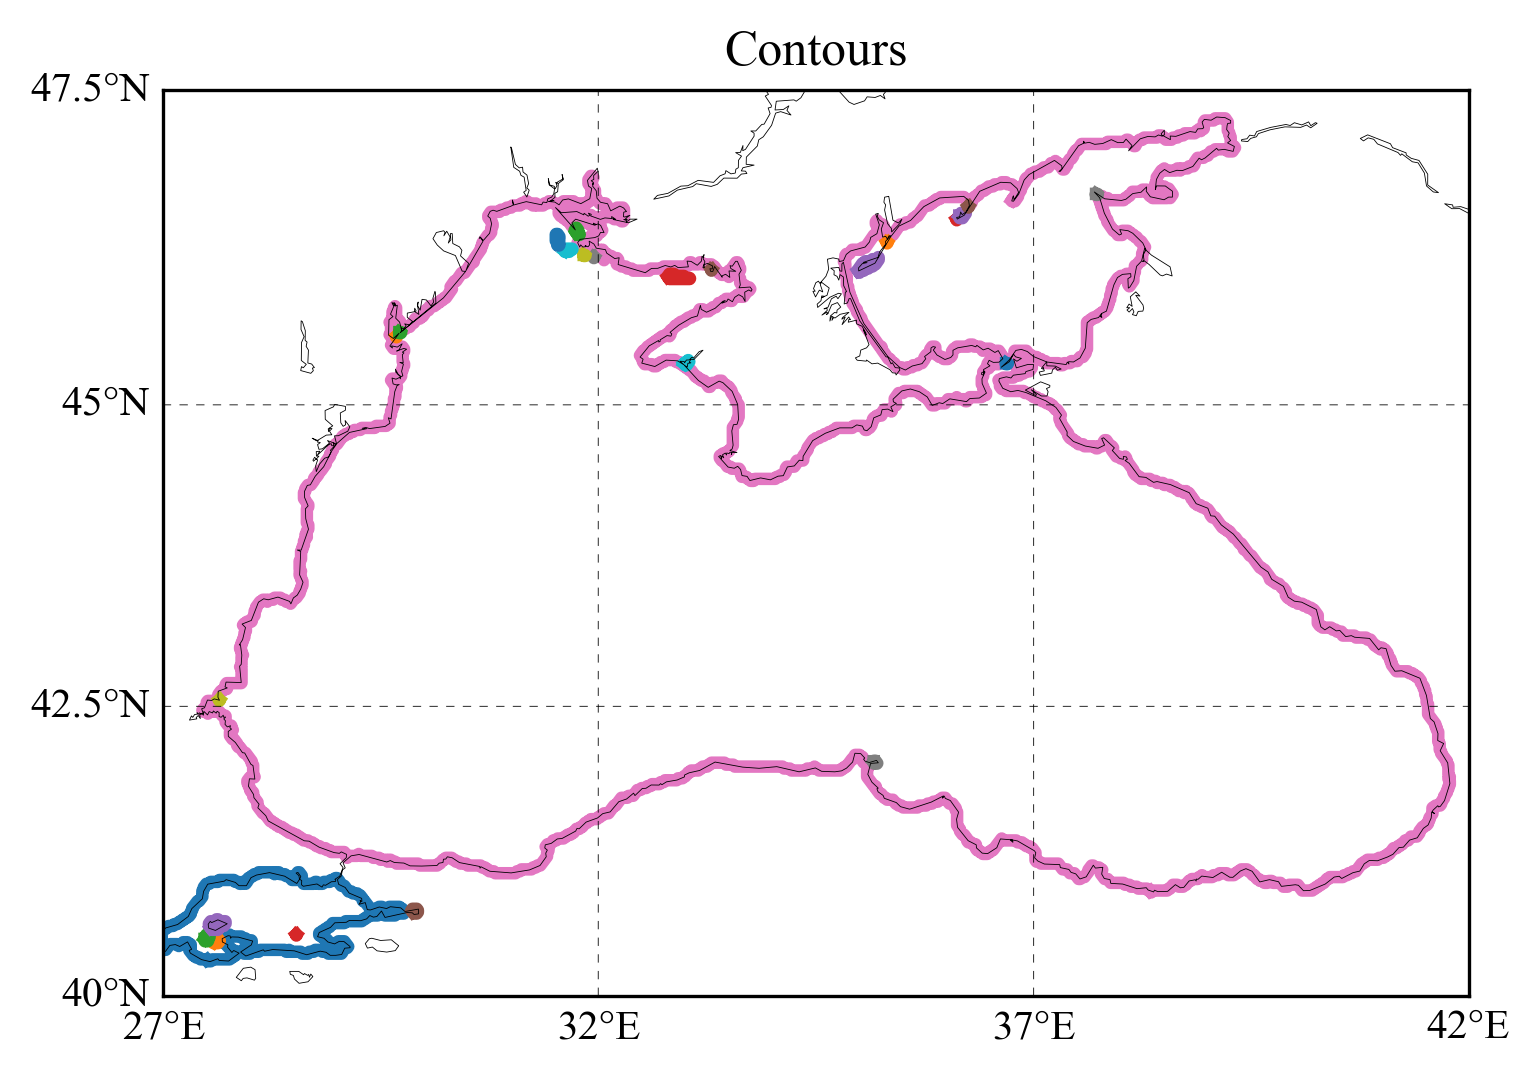

In [23]:
fig = plt.figure()
ax = plt.subplot(111)
m.ax = ax
Contour.add_to_plot(m=m, linewidth=3)
m.drawmeridians(np.linspace(Param.xori, Param.xend, 4), labels=[0, 0, 0, 1], linewidth=0.2)
m.drawparallels(np.linspace(Param.yori, Param.yend, 4), labels=[1, 0, 0, 0], linewidth=0.2)
m.drawcoastlines(linewidth=0.2, zorder=3)
plt.title('Contours')
plt.savefig(os.path.join(figdir, 'contours.png'))
plt.show()
plt.close()

## Finite element mesh

To create the plot, we add the option *m* in the `add_to_plot` method.     
Take into account that this plot generation can be relatively slow for a dense mesh.

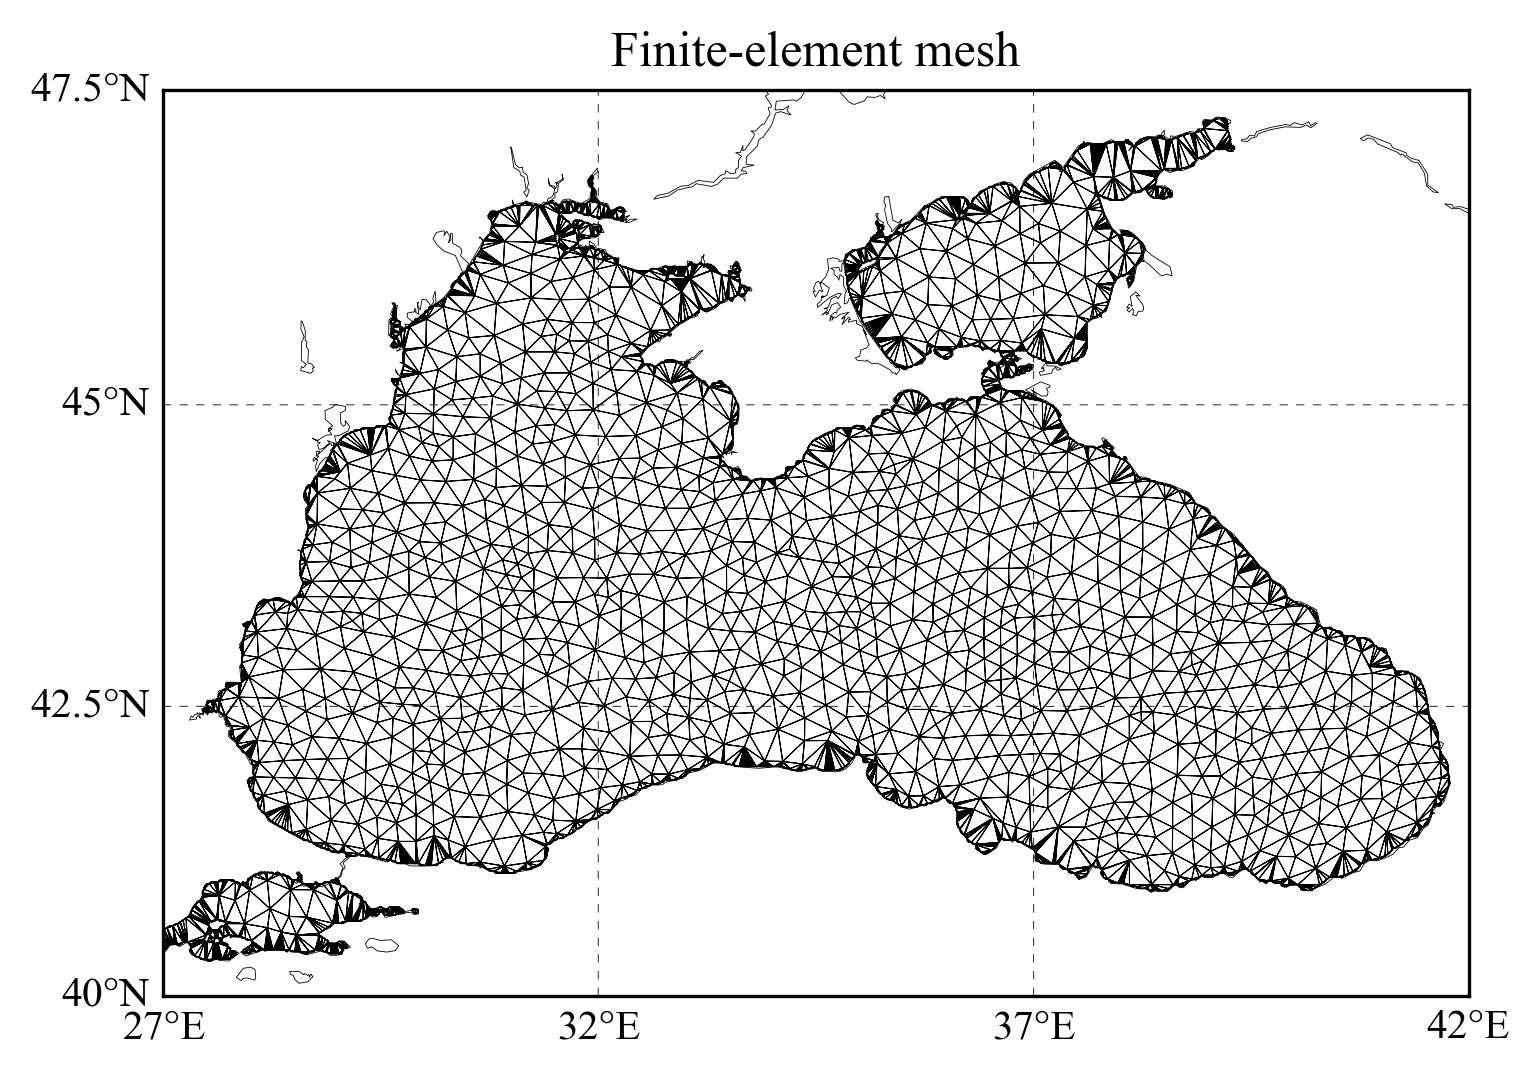

In [30]:
fig = plt.figure()
ax = plt.subplot(111)
m.ax = ax
mesh2d.add_to_plot(m, linewidth=0.25, color='k')
m.drawmeridians(np.linspace(Param.xori, Param.xend, 4), labels=[0, 0, 0, 1], linewidth=0.2)
m.drawparallels(np.linspace(Param.yori, Param.yend, 4), labels=[1, 0, 0, 0], linewidth=0.2)
m.drawcoastlines(linewidth=0.2, zorder=3)
plt.title("Finite-element mesh")
plt.savefig(os.path.join(figdir, 'mesh.png'))
plt.show()
plt.close()

## Analysed field

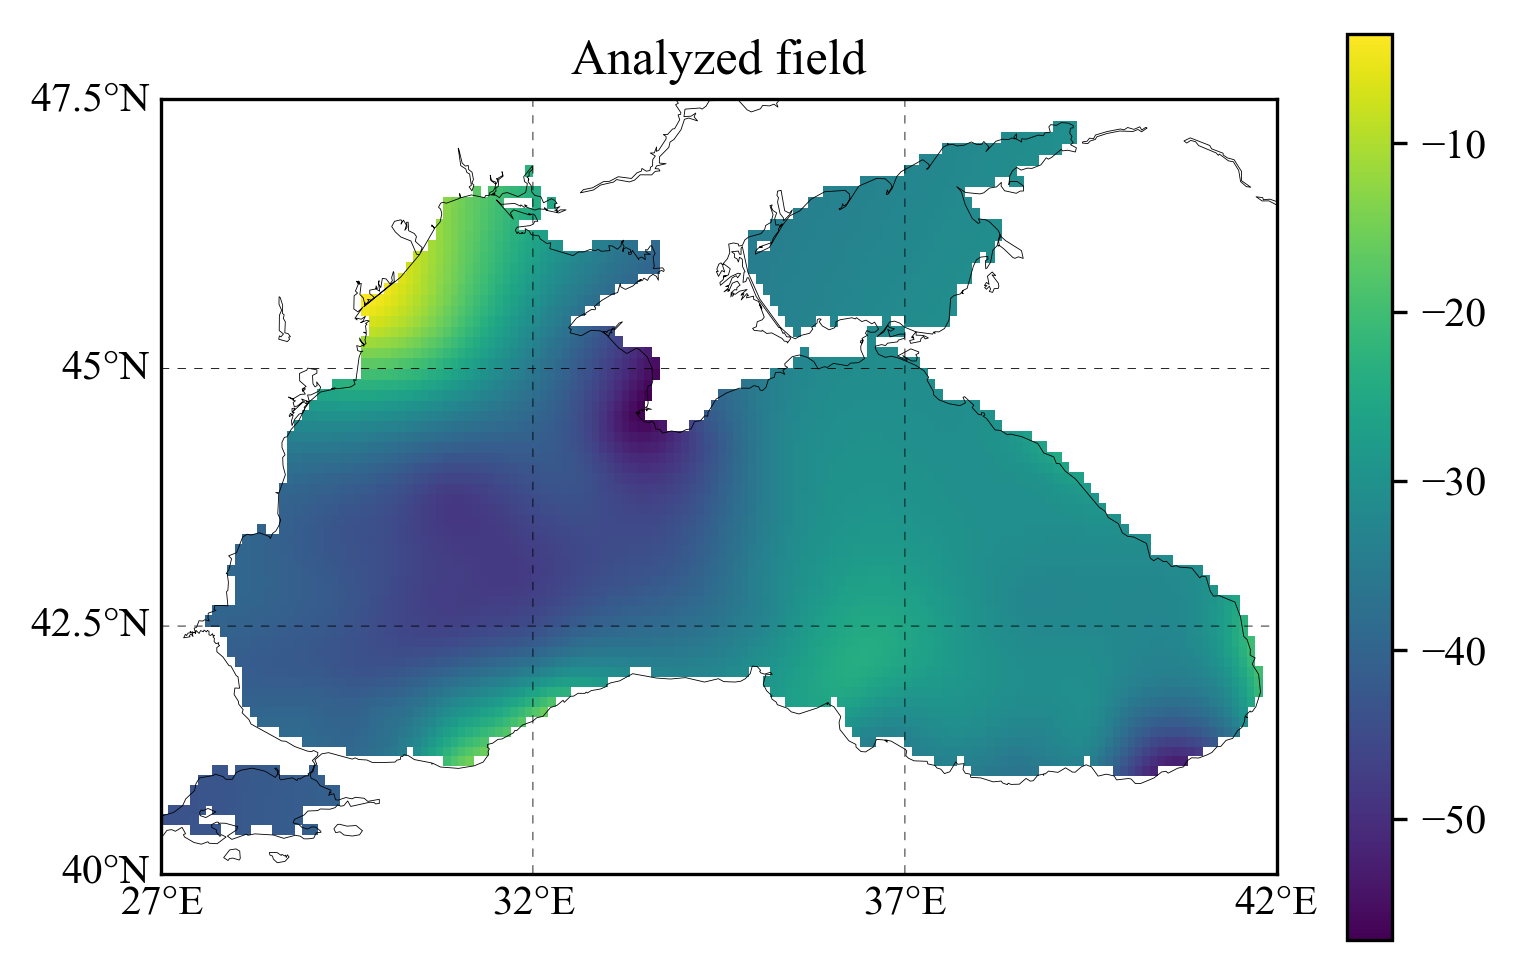

In [41]:
fig = plt.figure()
ax = plt.subplot(111)
m.ax = ax
FieldPlot = analysis2d.add_to_plot(field='analysis', m=m)
m.drawmeridians(np.linspace(Param.xori, Param.xend, 4), labels=[0, 0, 0, 1], linewidth=0.2)
m.drawparallels(np.linspace(Param.yori, Param.yend, 4), labels=[1, 0, 0, 0], linewidth=0.2)
m.drawcoastlines(linewidth=0.2, zorder=3)
plt.colorbar(FieldPlot)
plt.title('Analyzed field')
plt.savefig(os.path.join(figdir, 'analysis.png'))
plt.show()
plt.close()

# Final remarks

* The different elements of the plot can be combined in many ways (see example below).
* All the plots can be easily modified by adapting the diffent options: colors, projection, font size etc.

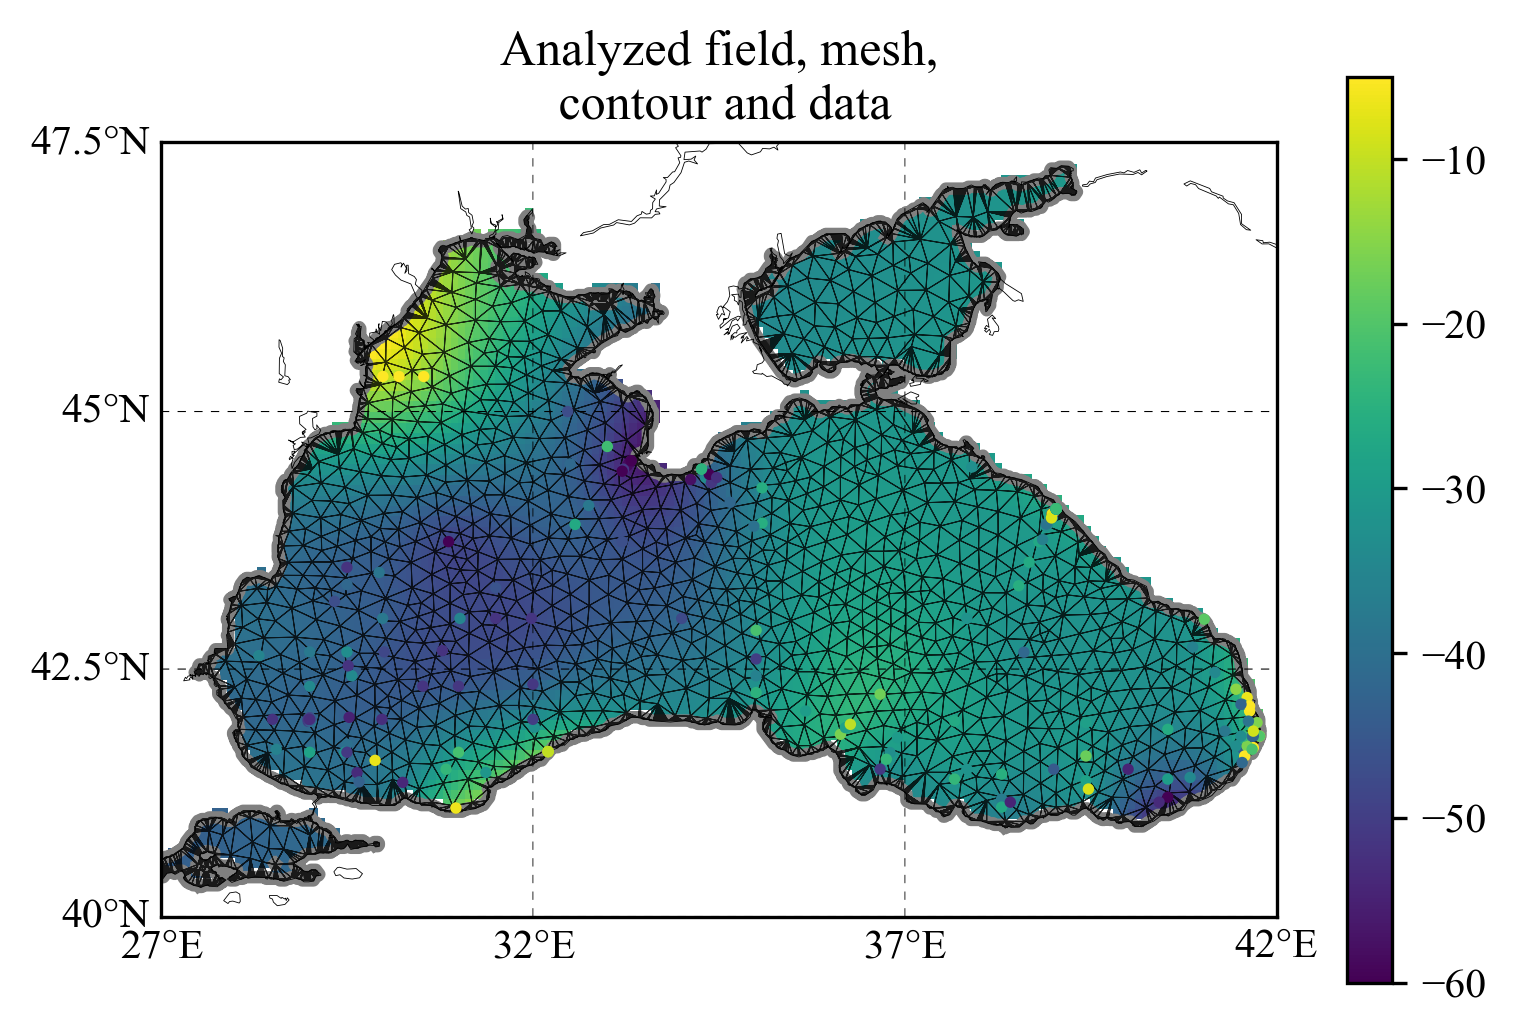

In [44]:
fig = plt.figure()
ax = plt.subplot(111)
m.ax = ax
fieldplot = analysis2d.add_to_plot(m=m, vmin=-60, vmax=-5)
mesh2d.add_to_plot(m=m, alpha=0.8, linewidth=0.25, color='k', zorder=4)
Contour.add_to_plot(m=m, linewidth=3, color='0.5')
Data.add_to_plot(m=m, s=3, vmin=-60, vmax=-5, zorder=5)
m.drawmeridians(np.linspace(Param.xori, Param.xend, 4), labels=[0, 0, 0, 1], linewidth=0.2)
m.drawparallels(np.linspace(Param.yori, Param.yend, 4), labels=[1, 0, 0, 0], linewidth=0.26)
m.drawcoastlines(linewidth=0.2, zorder=3)
plt.colorbar(fieldplot)
plt.title('Analyzed field, mesh,\n contour and data')
plt.savefig(os.path.join(figdir, 'AnalysisMeshData.png'))
plt.show()
plt.close()